In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from os.path import *
from os import *
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [10]:
cwd = getcwd()

In [11]:
pchs = pd.read_csv(cwd + "\\QVI_purchase_behaviour.csv")
tras = pd.read_excel(cwd + "\\QVI_transaction_data2.csv")

In [12]:
pchs.shape

(72637, 3)

In [13]:
tras.shape

(264836, 8)

## Work with transaction data

In [14]:
#Convert date from numbers to date
def xldate_to_datetime(xldate):
	temp = datetime.datetime(1900, 1, 1)
	delta = datetime.timedelta(days=xldate-2)
	return (temp+delta).date().strftime('%Y-%m-%d')


In [15]:
tras['DATE'] = tras['DATE'].apply(xldate_to_datetime)

#### PROD_NAME - Double check product categories

In [16]:
PROD = pd.Series(tras['PROD_NAME'].unique())
PROD_split = PROD.str.split()
PROD_list = []
for x in PROD_split:
    PROD_list.extend(x)
PROD_list_clean = [word for word in PROD_list if "&" not in word and not any(c.isdigit() for c in word) ]
PROD_list_clean[:5]

['Natural', 'Chip', 'Compny', 'CCs', 'Nacho']

In [17]:
PROD_freq = {}
for word in PROD_list_clean:
    if word in PROD_freq.keys():
        PROD_freq[word] = PROD_freq[word] + 1
    else:
        PROD_freq[word] = 1

PROD_freq = {k: v for k, v in sorted(PROD_freq.items(), key=lambda item: item[1],reverse=True)}


Remove Salsa related records - non-chip category

In [19]:
tras = tras[~tras['PROD_NAME'].str.contains('(?i)salsa')]
tras.shape

(246742, 8)

Check data sanity: missing and outliers

In [21]:
tras.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [22]:
tras.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

In [23]:
pchs.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

Look into outliers - PROD_QTY = 200, TOT_SALES = 650

In [26]:
tras[tras['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


See if customer 226000 has other transactions

In [27]:
tras[tras['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


Remove outliers - since our focus is retail instead of commercial purchases

In [28]:
tras = tras[tras['PROD_QTY'] != 200]
tras.shape

(246740, 8)

Time window

In [29]:
min(tras['DATE'])

'2018-07-01'

In [30]:
max(tras['DATE'])

'2019-06-30'

Count number of transactions by date

In [32]:
trans_date = tras.groupby('DATE')['PROD_NAME'].count()
trans_date

DATE
2018-07-01    663
2018-07-02    650
2018-07-03    674
2018-07-04    669
2018-07-05    660
             ... 
2019-06-26    657
2019-06-27    669
2019-06-28    673
2019-06-29    703
2019-06-30    704
Name: PROD_NAME, Length: 364, dtype: int64

364 days - 1 day missing

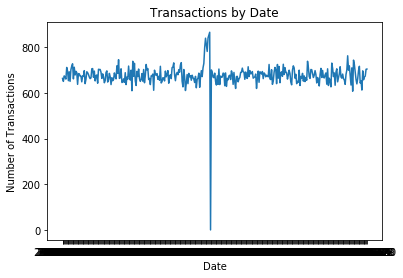

In [33]:
base = datetime.datetime(2018,7,1)
datediff = (datetime.datetime(2019,6,30) - base).days +1
date_list = [base + datetime.timedelta(days=x) for x in range(datediff)]
date_list = [x.date().strftime('%Y-%m-%d') for x in date_list]
date_list = pd.DataFrame(date_list,columns = ['DATE'])
    
#merge trans_date with date_list
tras_filled = date_list.merge(trans_date,how = 'left', on = "DATE").fillna(0)
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Transactions by Date')
plt.plot(tras_filled['DATE'], tras_filled['PROD_NAME'])
plt.show()

In [39]:
tras_filled[tras_filled['PROD_NAME']==0]

,DATE,PROD_NAME
177,2018-12-25,0.0


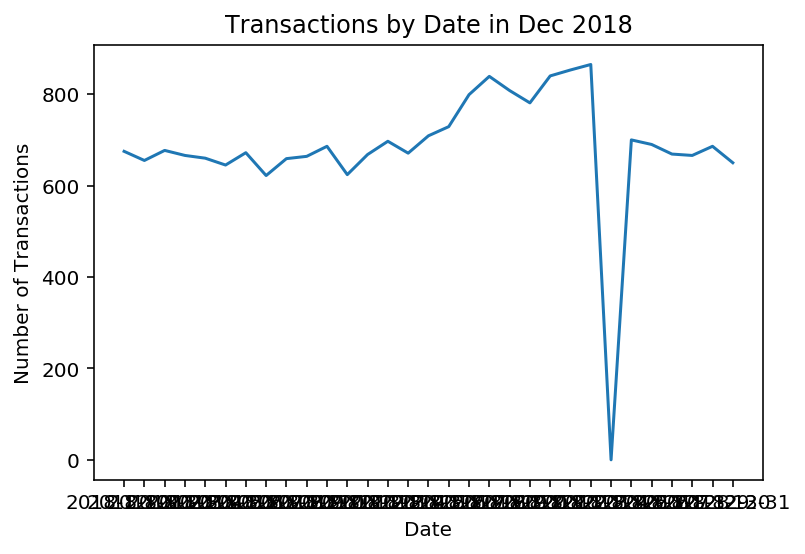

In [40]:
#plot december separately
Dec_date = [x for x in tras_filled['DATE'] if datetime.datetime.strptime(x,'%Y-%m-%d').month == 12]
Dec_tras = tras_filled.loc[tras_filled['DATE'].isin(Dec_date)]

plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Transactions by Date in Dec 2018')
plt.plot(Dec_tras['DATE'], Dec_tras['PROD_NAME'])
plt.show()


In [41]:
##dig into pack size
PROD_size = [word for word in PROD_list if any(c.isdigit() for c in word)]
PROD_size_dgt = [int(''.join(filter(str.isdigit,word))) for word in PROD_size ]
pd.DataFrame(PROD_size_dgt).describe()

,0
count,114.000000
mean,180.192982
std,59.757901
min,70.000000
25%,150.000000
50%,170.000000
75%,175.000000
max,380.000000


In [43]:
#add a column, SIZE
tras_size_dgt = [int(''.join(filter(str.isdigit,word))) for word in tras['PROD_NAME'] ]
tras['SIZE'] = tras_size_dgt

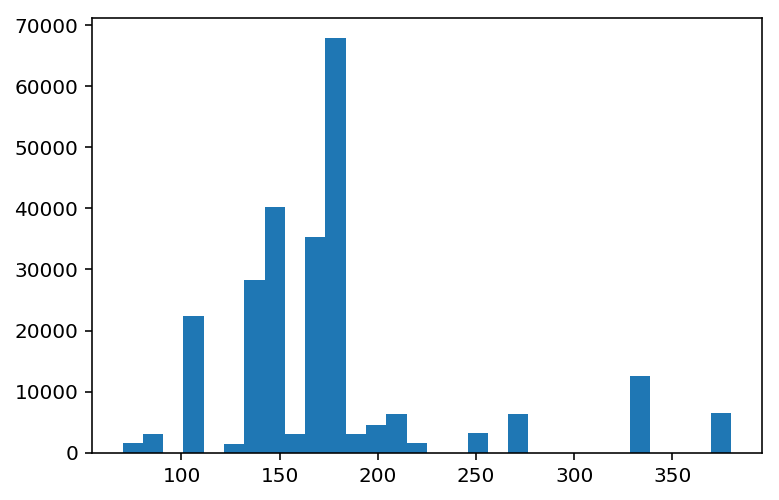

In [44]:
#group by size
tras_size = tras.groupby("SIZE")['PROD_NAME'].count().sort_values(ascending = False)
#histogram
plt.hist(tras_size_dgt,bins = 30)
plt.show()

In [46]:
##Brand
PROD_NAME_split = tras['PROD_NAME'].str.split()
Brand = [x[0] for x in PROD_NAME_split]

tras['Brand'] = Brand
tras.loc[tras['Brand']=='Red','Brand'] = 'RRD'

groupby_brand = tras.groupby('Brand')['PROD_NAME'].count().sort_values(ascending = False).reset_index()
groupby_brand


,Brand,PROD_NAME
0,Kettle,41288
1,Smiths,27390
2,Pringles,25102
3,Doritos,22041
4,RRD,16321
5,Thins,14075
6,Infuzions,11057
7,WW,10320
8,Cobs,9693
9,Tostitos,9471


## Work with customer data

In [48]:
pchs['LIFESTAGE'].value_counts()

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

In [50]:
pchs['PREMIUM_CUSTOMER'].value_counts()

Mainstream    29245
Budget        24470
Premium       18922
Name: PREMIUM_CUSTOMER, dtype: int64

In [51]:
#merge transaction data with customer data, and check if they merge sucessfully
Merge = pd.merge(pchs, tras, how = 'right', left_on = "LYLTY_CARD_NBR", right_on = "LYLTY_CARD_NBR", suffixes = ('_p','_t'))
Merge.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
SIZE                0
Brand               0
dtype: int64

In [52]:
##write to csv
Merge.to_csv("L:\\AFTER\\AB testing\\VI_Quantium\\Merge.csv",index = False)

## Identify Metrics

- Who spends the most on chips (total sales), describing customers by lifestage and
how premium their general purchasing behaviour is
- How many customers are in each segment
- How many chips are bought per customer by segment
- What's the average chip price by customer segment


In [53]:
#total sales by LIFESTAGE and PREMIUM_CUSTOMER

tot_sales = Merge.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['TOT_SALES'].agg('sum').sort_values(ascending = False).reset_index()
avg_sales = Merge.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['TOT_SALES'].agg('mean').sort_values(ascending = False).reset_index()

In [54]:
tot_sales[:3]

,PREMIUM_CUSTOMER,LIFESTAGE,TOT_SALES
0,Budget,OLDER FAMILIES,156863.75
1,Mainstream,YOUNG SINGLES/COUPLES,147582.20
2,Mainstream,RETIREES,145168.95


In [55]:
avg_sales[:3]

,PREMIUM_CUSTOMER,LIFESTAGE,TOT_SALES
0,Mainstream,MIDAGE SINGLES/COUPLES,7.637156
1,Mainstream,YOUNG SINGLES/COUPLES,7.551279
2,Premium,RETIREES,7.461315


In [56]:
#total quantity by LIFESTAGE and PRIMIUM_CUSTOMER
tot_qty = Merge.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['PROD_QTY'].agg('sum').sort_values(ascending = False).reset_index()
avg_qty = Merge.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['PROD_QTY'].agg('mean').sort_values(ascending = False).reset_index()

In [58]:
tot_qty

,PREMIUM_CUSTOMER,LIFESTAGE,PROD_QTY
0,Budget,OLDER FAMILIES,41853
1,Mainstream,RETIREES,37677
2,Mainstream,YOUNG SINGLES/COUPLES,36225
3,Budget,YOUNG FAMILIES,34482
4,Budget,OLDER SINGLES/COUPLES,32883
5,Mainstream,OLDER SINGLES/COUPLES,32607
6,Premium,OLDER SINGLES/COUPLES,31695
7,Budget,RETIREES,26932
8,Mainstream,OLDER FAMILIES,25804
9,Premium,RETIREES,23266


In [59]:
avg_qty

,PREMIUM_CUSTOMER,LIFESTAGE,PROD_QTY
0,Mainstream,OLDER FAMILIES,1.948795
1,Premium,OLDER FAMILIES,1.945496
2,Budget,OLDER FAMILIES,1.945384
3,Mainstream,YOUNG FAMILIES,1.941408
4,Budget,YOUNG FAMILIES,1.941226
5,Premium,YOUNG FAMILIES,1.938149
6,Budget,OLDER SINGLES/COUPLES,1.914920
7,Premium,OLDER SINGLES/COUPLES,1.913949
8,Mainstream,MIDAGE SINGLES/COUPLES,1.911942
9,Mainstream,OLDER SINGLES/COUPLES,1.911201


In [63]:
#average price paid by each segment
avg_price = pd.merge(tot_sales, tot_qty, on=['PREMIUM_CUSTOMER','LIFESTAGE'])
avg_price['avg_price'] = avg_price.TOT_SALES/avg_price.PROD_QTY
avg_price.sort_values("avg_price", ascending = False)

,PREMIUM_CUSTOMER,LIFESTAGE,TOT_SALES,PROD_QTY,avg_price
1,Mainstream,YOUNG SINGLES/COUPLES,147582.20,36225,4.074043
11,Mainstream,MIDAGE SINGLES/COUPLES,84734.25,21213,3.994449
19,Mainstream,NEW FAMILIES,15979.70,4060,3.935887
7,Budget,RETIREES,105916.30,26932,3.932731
18,Budget,NEW FAMILIES,20607.45,5241,3.931969
9,Premium,RETIREES,91296.65,23266,3.924037
6,Premium,OLDER SINGLES/COUPLES,123537.55,31695,3.897698
4,Budget,OLDER SINGLES/COUPLES,127833.60,32883,3.887529
20,Premium,NEW FAMILIES,10760.80,2769,3.886168
2,Mainstream,RETIREES,145168.95,37677,3.852986


In [64]:
#prepare for t-test
Merge['Segment'] = Merge['PREMIUM_CUSTOMER'] + '/' + Merge['LIFESTAGE']
Merge['Price'] = Merge['TOT_SALES']/Merge['PROD_QTY']

T-test：
Mainstream vs Budget/Premium for both Young singles/couples and Midage singels/couples

(array([1.000e+00, 0.000e+00, 2.660e+02, 2.700e+02, 2.080e+02, 6.100e+01,
        6.400e+01, 4.670e+02, 4.300e+01, 1.027e+03, 4.500e+01, 4.630e+02,
        0.000e+00, 9.800e+02, 8.570e+02, 0.000e+00, 3.010e+02, 7.270e+02,
        7.240e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.640e+02,
        0.000e+00, 3.450e+02, 1.020e+02, 0.000e+00, 0.000e+00, 9.700e+01]),
 array([1.35      , 1.52166667, 1.69333333, 1.865     , 2.03666667,
        2.20833333, 2.38      , 2.55166667, 2.72333333, 2.895     ,
        3.06666667, 3.23833333, 3.41      , 3.58166667, 3.75333333,
        3.925     , 4.09666667, 4.26833333, 4.44      , 4.61166667,
        4.78333333, 4.955     , 5.12666667, 5.29833333, 5.47      ,
        5.64166667, 5.81333333, 5.985     , 6.15666667, 6.32833333,
        6.5       ]),
 <a list of 30 Patch objects>)

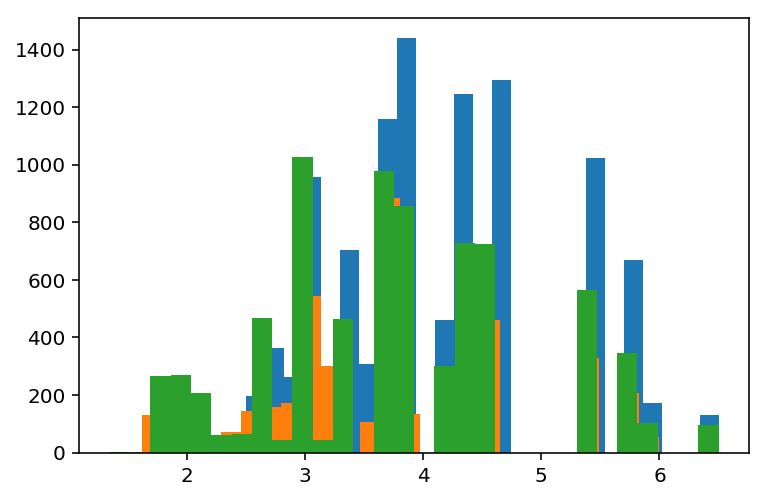

In [65]:
M1 = Merge.loc[Merge['Segment'] == 'Mainstream/MIDAGE SINGLES/COUPLES', 'Price' ].reset_index()['Price']
M2 = Merge.loc[Merge['Segment'] == 'Budget/MIDAGE SINGLES/COUPLES', 'Price' ]
M3 = Merge.loc[Merge['Segment'] == 'Premium/MIDAGE SINGLES/COUPLES', 'Price' ]

Y1 = Merge.loc[Merge['Segment'] == 'Mainstream/YOUNG SINGLES/COUPLES', 'Price' ]
Y2 = Merge.loc[Merge['Segment'] == 'Budget/YOUNG SINGLES/COUPLES', 'Price' ]
Y3 = Merge.loc[Merge['Segment'] == 'Premium/YOUNG SINGLES/COUPLES', 'Price' ]

plt.hist(M1,bins = 30)
plt.hist(M2, bins = 30)
plt.hist(M3, bins =30)


In [66]:
M12 = stats.ttest_ind(M1, M2, equal_var = False)
M13 = stats.ttest_ind(M1, M3, equal_var = False)

Y12 = stats.ttest_ind(Y1, Y2, equal_var = False)
Y13 = stats.ttest_ind(Y1, Y3, equal_var = False)

In [67]:
M12

Ttest_indResult(statistic=13.460396219135559, pvalue=7.064596224405283e-41)

In [68]:
M13

Ttest_indResult(statistic=14.058650719224476, pvalue=1.270504516965566e-44)

In [69]:
Y12

Ttest_indResult(statistic=29.522268430576936, pvalue=2.795698078075004e-186)

In [70]:
Y13

Ttest_indResult(statistic=24.777379661429585, pvalue=4.0639607782009104e-131)

In [74]:
#take a look at brand bought by Mainstream Young single/couple

M_brand = Merge.loc[Merge['PREMIUM_CUSTOMER'] == 'Mainstream'].groupby('Brand')['PROD_NAME'].count().sort_values(ascending = False)
M_brand[:3]

Brand
Kettle      16423
Smiths      10246
Pringles     9903
Name: PROD_NAME, dtype: int64

In [77]:
Y_brand = Merge.loc[Merge['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES'].groupby('Brand')['PROD_NAME'].count().sort_values(ascending = False)
Y_brand[:3]

Brand
Kettle      5893
Pringles    3684
Smiths      3555
Name: PROD_NAME, dtype: int64

In [78]:
#Size
M_size = Merge.loc[Merge['PREMIUM_CUSTOMER'] == 'Mainstream'].groupby('SIZE')['PROD_NAME'].count().sort_values(ascending = False)
M_size[:3]


SIZE
175    25143
150    15487
134     9903
Name: PROD_NAME, dtype: int64

In [80]:
Y_Size = Merge.loc[Merge['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES'].groupby('SIZE')['PROD_NAME'].count().sort_values(ascending = False)
Y_Size[:3]


SIZE
175    8953
150    5403
134    3684
Name: PROD_NAME, dtype: int64